# IMA 208 TP5: homography estimation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In this practical work, we will study how to estimate an homography between two given images. We will consider both the simple DLT algorithm (part I) and the RANSAC algorithm (part II).

To reduce the time you need for this practical work, we will use a few pre-implemented functions of openCV. Make sure that your library installation is correct before starting to work.

# Part 1: homography estimation from hand-selected keypoints: DLT algorithm

We assume that we have an image of a documents suffering from severe perspective distortion. The objective of this part is to warp this image (denoted in the following as img2) to remove the distortion using a reference image beeing in the desired pose (denoted as img1).

The following cell enables to vizualize the images using openCV.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7e3edc71b590>)

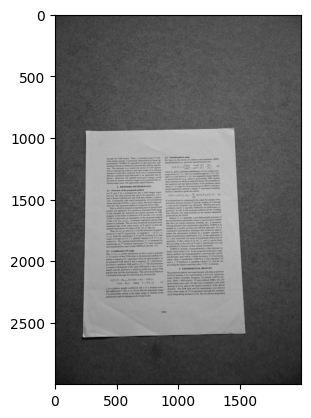

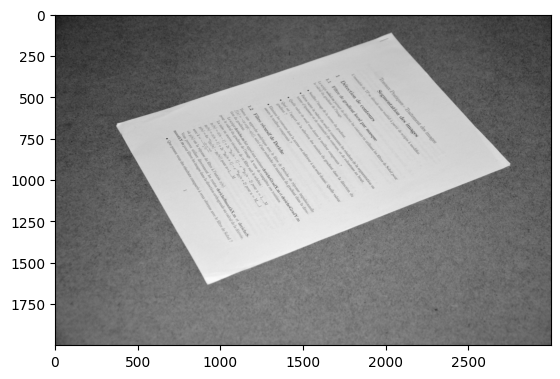

In [2]:
img1 = cv2.cvtColor(cv2.imread('Feuille_redressee.jpg'),cv2.COLOR_BGR2GRAY) # Reference image
img2 = cv2.cvtColor(cv2.imread('Feuille.jpg'),cv2.COLOR_BGR2GRAY) # Image to be processed

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To correct the homography beetween the to images, we will need some points to match between the two images.

**Question:** how many points do you at least need to estimate the homography? Why?

**Answer:** On a besoin d'au moins 4 points pour estimer une homographie puisqu'une homographie entre deux images possède 8 degrés de liberté et que chaque point possède deux coordonnées. Cependant, si nos images sont bruitées il est préférable d'en utiliser plus.

**Implementation:** to estimate the homography, some matching keypoints between the reference image and the to-be-porcessed one are given below. They here correspond to the corners of the two documents.

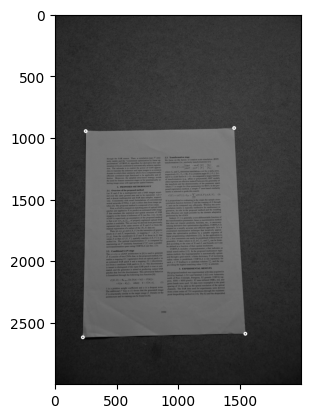

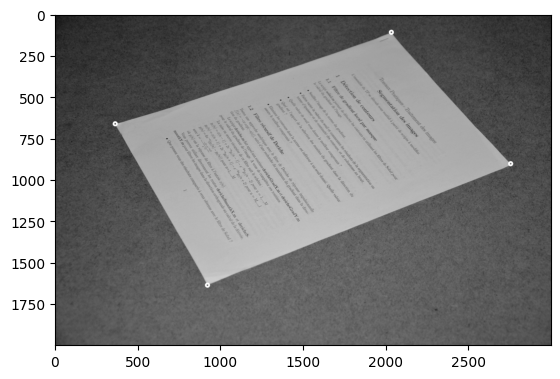

In [3]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]] # Keypoints for img1. Should be a list in format [[first_point_row,first_point_column],[second_point_row,second_point_column],...]
pts2 = [[2030,110],[2750,904],[920,1638],[363,663]] # Keypoints for img2,  keep the same order of the points as pts1.

# Below, we convert the points you found above into cv2 points object for vizualization (no need to change anything)
kp1 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts1]
kp2 = [cv2.KeyPoint(pt[0], pt[1], 1) for pt in pts2]

for i in range(len(pts1)):
    img1c=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c,cmap='gray')

for i in range(len(pts2)):
    img2c=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2,number_of_points

**Visualize** the keypoints you found above to check that they are properly assigned.

Now, we will start implementing the DLT.

**Question:** recall what the DLT is. Give a pseudo code. What are its potential flaws and strengths?

**Answer:** DLT ou Direct linear transform est un algorithme qui a pour objectif d'estimer la matrice de l'homographie 2D H telle que $x_i' = Hx_i$ i.e. $x_i' x Hx_i = 0$ où x est un produit vectoriel. Pour faciliter ce calcul, on cherche plutôt à résoudre $Ah = 0$.

Le pseudo-code de cet algorithme est donc :
* Pour chaque correspondance $x_i'<-> x_i$, on calcule $A_i$ en effectuant une minimisation sous contrainte de la norme de $A_ih$.
* On calcule A en concaténant les $A_i$.
* On effectue la décomposition SVD de A pour trouver la plus petite valeur propre de A. Le vecteur propre correspondant dans V est h.
* h est une matrice de dimension 9x1 qu'on transforme en matrice 3x3 pour avoir H.

Les défauts de DLT : il est sensible aux outliers et au bruit.

La force de DLT : il est très facile à mettre en place.

The first step of the DLT algorithm is to normalize the image point.

**Question:** Recall why the normalization is important. Recall how to do it.

**Answer:** La normalisation est importante dans l'algorithme DLT car les magnitudes des coefficients de A appartiennent à des ordres de grandeur très différents (typiquement entre 1 et 10000). Le comportement est donc très mauvais lorsqu'on essaie de résoudre le système.

Pour normaliser on doit calculer une matrice de similarité T qui translate et met à l'échelle les xi, en mettant le centroïde à l'origine et la distance standard à $\sqrt{2}$. Pour cela, on calcule la moyenne et la distance moyenne des x et des y, respectivement $m_x, m_y, std_x, std_y$. T vaut alors
\begin{equation}
\begin{pmatrix}
  1       & std_x / \sqrt{2}  & m_x \\
  0       &  std_y / \sqrt{2} & m_y\\
  0 & 0 & 1 \\
\end{pmatrix}
\end{equation}

On applique ensuite T à chaque $x_i$.

In the following, we will perform the normalization using the so called *homogeneous* coordinates of the keypoints. The main idea is to add a last coordinate equal to one for each point. The point (x,y) thus becomes (x,y,1) in homogeneous coordinate.

The advantage is that we will be able to do the normalization using a simple matrix product : X_norm = T@X.

**Fill** the blanks in the below implementation.

In [12]:
def normalize_image_points(imageEucl):
    """
    Input: 2D list with x,y image points
    Output: normalized data points
    """

    print("Normalizing data using similarity matrix...")

    mean, std = np.mean(imageEucl,axis=1), np.std(imageEucl, axis=1) # To be filled, (elementwise) mean and std of the data points

    dim_x = np.shape(imageEucl)[1]

    image = np.ones((3, dim_x))
    image[0:2,:] = imageEucl # Image in homogeneous coordinate

    # Define a similarity matrix enabling to normalize the data. Write the cooefficients in Tranformation such that image_norm = image@Transformation
    Transformation = np.array([[std[0]/np.sqrt(2), 0, mean[0]],
                               [0, std[1]/np.sqrt(2), mean[1]],
                               [0,0 ,1]])
    Transformation = np.linalg.inv(Transformation)

    # Apply transformation on data points
    image_norm = Transformation@image

    # Retrieve normalized image in the original input shape (25, 2)
    image_norm = image_norm[0:2,:]

    return image_norm, Transformation




**Question:** Verify that your data looks properly normalized.

**Answer :** They look properly normalized.

In [13]:
normalize_image_points(np.array(pts1))

Normalizing data using similarity matrix...


(array([[-1.38645288,  1.31017554,  1.5143296 , -1.43805226],
        [-1.39285967, -1.43519583,  1.38947278,  1.43858272]]),
 array([[ 2.24345127e-03,  0.00000000e+00, -1.94282880e+00],
        [ 0.00000000e+00,  1.69344641e-03, -2.99994031e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

The second step is to compute the A matrix from the normalized data points.

**Fill** the blanks in the function below.

**Question:** justify the shape of the A matrix.

**Answer:** Il faut que A résolve l'équation $Ah = 0$. Il faut donc que A ait 9 colonnes. De plus, pour chaque keypoint, A possède deux lignes. A a donc 2*nombre_de_keypoints ligens.

In [14]:
def compute_matrix_A(points1, points2, no_points):
    """
    Input: Already normalized correspondences for image1 and image2
    Output: Matrix A as defined in Zisserman p. 91
    """

    A = []

    for i in range(0, no_points):
        x, y = points1[0, i], points1[1, i] # Denote the coordinate in image 1 x and y for shortcut
        x_prime, y_prime = points2[0, i], points2[1, i] # Denote the coordinate in image 2 x_prime and y_prime for shortcut

        # Create A_i according to the fomula given in class
        # here we are assuming w_i and w_i_prime are one
        A.append([0,0,0,-x, -y, -1, y_prime*x, y_prime*y, y_prime])
        A.append([x, y, 1, 0, 0, 0, -x_prime*x, -x_prime*y, -x_prime])

    print()
    print("Stacked matrix A shape:", np.shape(A))

    return np.asarray(A)



We are now ready to code the whole homography computation function.

**Fill** the gaps below.

In [15]:
def compute_homography(pts1,pts2):

    # Set data points to numpy arrays
    no_points = pts1.shape[1] # Number of points

    # Normalize the data
    image1_normalized, T = normalize_image_points(pts1)
    image2_normalized, T_prime = normalize_image_points(pts2)

    # Get matrix A
    # A = ...
    A = compute_matrix_A(image1_normalized, image2_normalized, no_points)

    # Compute SVD of A
    U, S, V = np.linalg.svd(A)

    V = V.T # So that A = USV.T

    # Get last column of V (this is the vector h)
    h = V[:,-1]

    # Obtain homography by reshaping h (H tilde)
    print()
    print("Reshaping to get homography H_tilde...")
    H_tilde = h.reshape((3,3))

    # Denormalize to obtain homography (H) using the transformations and generalized pseudo-inverse
    H = np.linalg.inv(T_prime)@ H_tilde @ T

    print()
    print("Denormalized to obtain homography H for 2D data points...")
    print("Matrix H:")
    print(H)

    return H

**Question:** Apply the compute_homography function to warp the document image 2 into the perspective of document 1. Any comment ?

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.89710151e-01 -6.17873517e-01  1.79973010e+03]
 [ 3.58788747e-01  2.07651631e-01 -2.17742589e+02]
 [-6.16844041e-05 -4.82980480e-06  6.40775923e-01]]


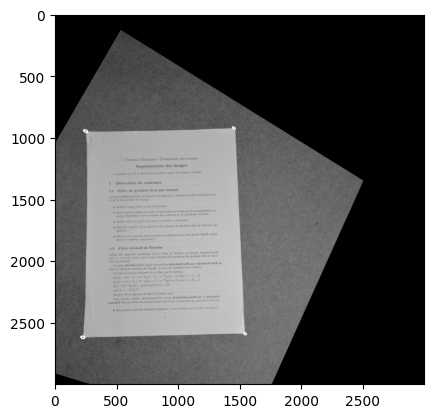

In [16]:
H = compute_homography(pts1,pts2)
homography_matrix_normalized = H
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

**Answer:** La feuille ressemble bien à celle de la première image. Le résultat est donc satisfaisant. Cependant, on observe du noir tout autour puisque la photo n'a pas assez de fond pour le remplir. Cela pourrait être intéressant de copier le fond pour compléter la nouvelle image.

**Question:** test the sensitivity of the above algorithm to errors in the matching keypoints. Are you able to obtain good results if you have a false match?

Answer to the same question is you have more matching points than the corners.

**Answer:** Notre algorithme est très sensible aux erreurs dans les matching keypoints. On reconnait la feuille si les valeurs ne sont pas trop éloignées des bons keypoints mais dès que l'on prend des valeurs plus éloignées le résultat est vraiment mauvais.

En rajoutant d'autres points, l'algorithme est un peu plus résistant.

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 9.54544338e-02 -7.52719817e-01  2.18712176e+03]
 [ 3.20657066e-01  1.13511253e-01 -7.50103805e+01]
 [-1.40188943e-04 -9.69827228e-05  8.75035137e-01]]


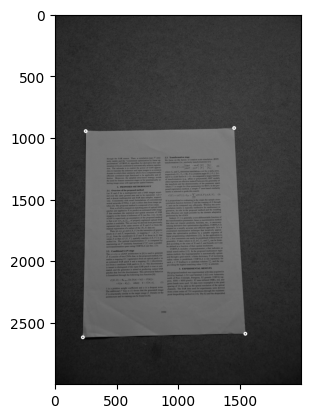

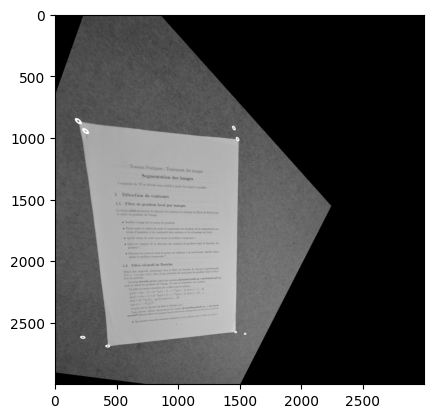

In [18]:
pts1 = [[248,949],[1450,924],[1541,2592],[225,2621]]
pts2 = [[2000,150],[2800,850],[940,1750],[400,500]]



for i in range(len(pts1)):
    img1c_dec=cv2.circle(img1,pts1[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img1c_dec,cmap='gray')

for i in range(len(pts2)):
    img2c_dec=cv2.circle(img2,pts2[i],radius=10,color=(255,0,0),thickness=10)
plt.figure(),plt.imshow(img2c_dec,cmap='gray')

pts1 = np.array(pts1).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points]
pts2 = np.array(pts2).T # In all the following, we will use the convention that np.shape(pts1) = [2xnumber_of_points

H = compute_homography(pts1,pts2)
homography_matrix_normalized = H / H[2, 2]
result = cv2.warpPerspective(img2, np.linalg.inv(homography_matrix_normalized),(3000,3000))
plt.imshow(result,cmap='gray')

# Part 2: automatic homography estimation and panorama stitching

To bypass the flaws that we observed with the previous method, we now propose to use a robust homography estimation method, the RANSAC algorithm. As an application, we will consider panorama stitching: from two given overlapping images, create a single one which is a panorama. To do that, we will need to estimate the best homography to warp an image into the perspective of the other. In addition, to avoid the cumbersome choice of the matching points between the two images, we will do an automatic keypoint identification by using the SIFT features.

Let us first load the two considered images.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7e3ebba94990>)

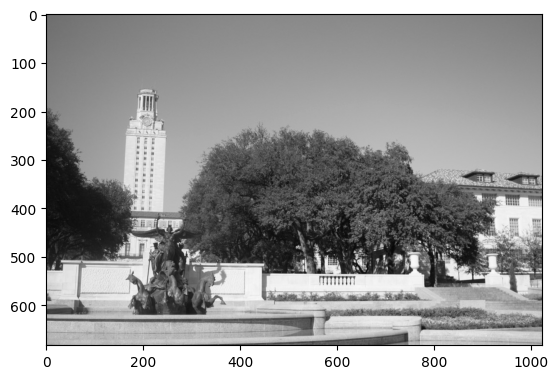

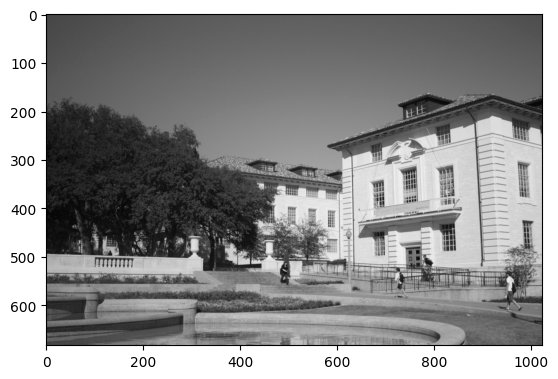

In [19]:
img1c = cv2.cvtColor(cv2.imread('uttower_left.jpg'),cv2.COLOR_BGR2GRAY)
img2c = cv2.cvtColor(cv2.imread('uttower_right.jpg'),cv2.COLOR_BGR2GRAY)

img1 = img1c
img2 = img2c

plt.figure(),plt.imshow(img1,cmap='gray')
plt.figure(),plt.imshow(img2,cmap='gray')

To stitch the two images, we need to have access to pair of corresponding points between image 1 and image 2. To do that, we first need to extract some keypoints in both images (that will be matched later on). We will use here the SIFT descriptors.

**Implement** the SIFT descriptors for both image 1 and image 2. You might be willing to use the cv2.SIFT_create and sift.detectAndCompute.

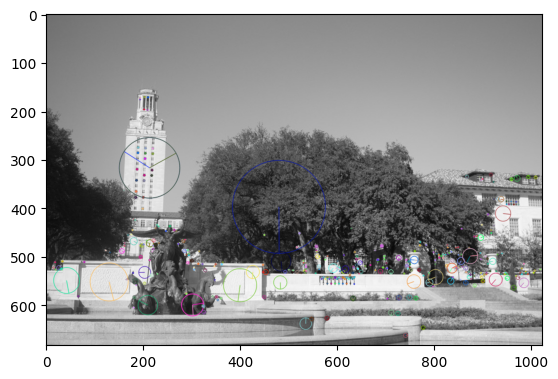

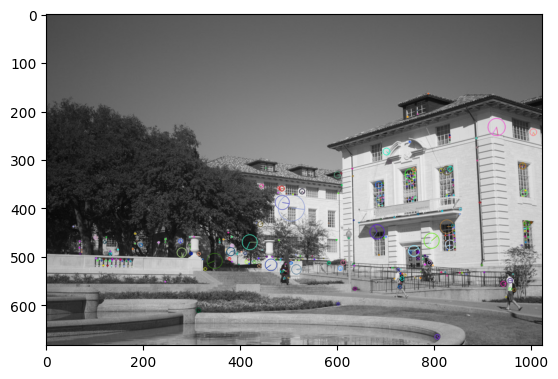

In [20]:
sift = cv2.SIFT_create(contrastThreshold = 0.15) # Creates an object of the SIFT class. The larger the threshold, the smaller the number of points
kp1,desc1 = sift.detectAndCompute(img1, None) #kp1 = location of the keypoints, desc1 = corresponding descriptors.

# For visualization
img1c=cv2.drawKeypoints(img1,kp1,img1c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img1c)
plt.show()

kp2,desc2 = sift.detectAndCompute(img2, None) #kp2 = location of the keypoints, desc2 = corresponding descriptors.
img2c=cv2.drawKeypoints(img2,kp2,img2c,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2c)

**Question:** explain the shapes of desc1, kp1 and desc2, kp2 and their respective roles.

**Answer:** Desc1 et desc2 sont les descripteurs des keypoints des deux images respectivement. Ce sont des tableaux numpy car un descripteur d'un keypoint est de taille 128. Ils servent à comparer les keypoints entre eux.

Kp1 et kp2 sont les localisations des keypoints des deux images. Ce sont des listes de keypoints. Le nombre de keypoints dépend du seuil. Ils décrivent le voisinage du keypoint correspondant.

Now that we have obtained the SIFT descriptor, we have to match them.

**Complete** the following code.

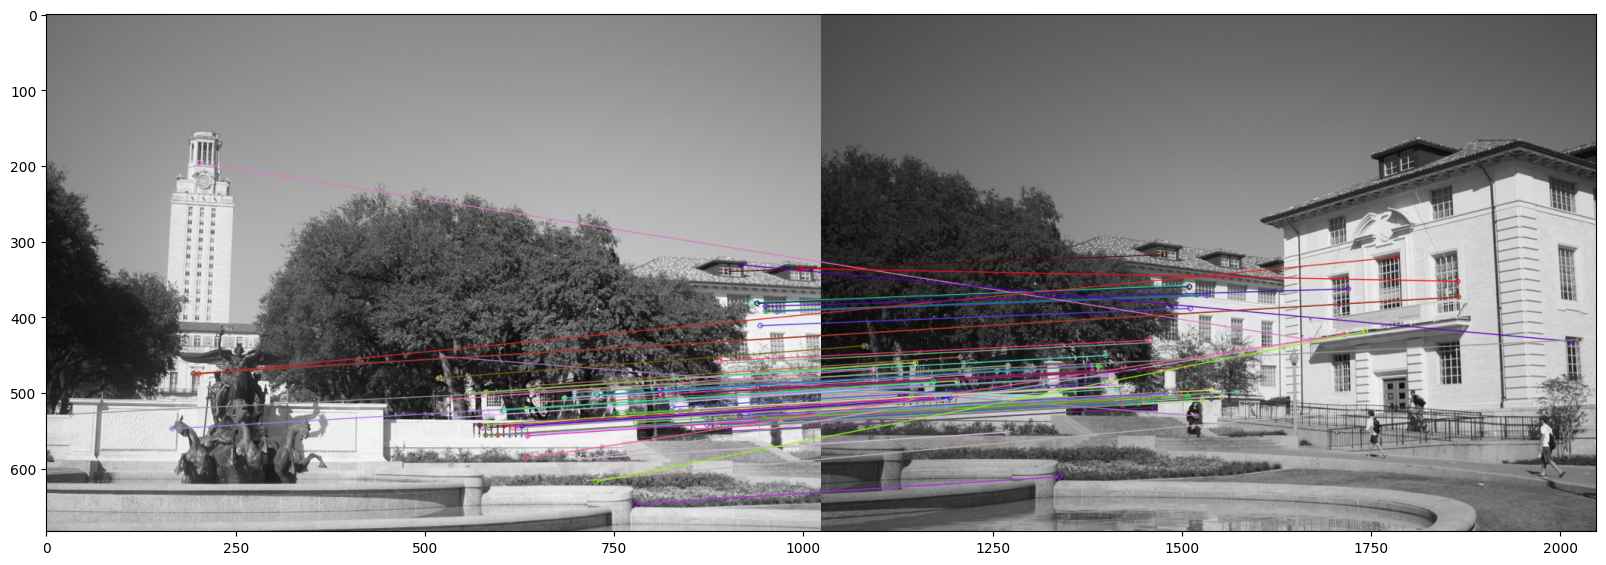

(<Figure size 2000x1200 with 1 Axes>,
 None)

In [22]:
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(desc1,desc2)

matches = sorted(matches, key = lambda x:x.distance)

# For visualizing the matches
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], img2, flags=2)
plt.figure(figsize=(20,12)),plt.imshow(img3),plt.show()

**Question:** comment the match quality. Do you think that the previous matching would enable a decent homography computation using the DLT algorithm of the first part?

**Answer:** La qualité de match est bonne lorsque les éléments apparaissent dans les deux images. En revanche, lorsqu'un élément n'apparait que dans une image, il peut être relié à un élément qui lui ressemble. Par exemple, dans la première image, le haut de la tour est relié à une fenêtre dans la deuxième.

Je pense que comme la majorité des matchs sont satisfaisants, cela devrait fonctionner avec DLT.

The following code enables to keep only the coordinates of the 100 best matches in the two images. We will use them as an input of a RANSAC, which will enable to do a robust homography estimation between the two images.

In [23]:
D1 = np.ones((2,100)) # Coordinates in image 1 of the first best matching points
D2 = np.ones((2,100)) # Coordinates in image 2 of the first best matching points
for ii in range(100):
    D1[:,ii] = kp1[matches[ii].queryIdx].pt
    D2[:,ii] = kp2[matches[ii].trainIdx].pt

D1 = D1.astype(int)
D2 = D2.astype(int)

In [24]:
print(D1.shape)

(2, 100)


Now, we are ready to code the RANSAC algorithm.

**Fill** the gaps in the code below.

In [34]:
def ransac(D1, D2, num, threshold, iterations):
    # D1, D2 : matched points between the two images
    # num : number of points to compute the homography
    # threshold : distance threshold for determining if a pair of point in an inlier or an outlier
    # iterations : number of iterations / number of sampling

    N1, M1 = np.shape(D1)
    N2, M2 = np.shape(D2)
    D1h = np.ones((N1+1, M1)) #D1h correspond to D1 transformed into homogeneous coordinates
    D1h[0:2,:] = D1

    D2h = np.ones((N2+1,M2)) #D2h correspond to D2 transformed into homogeneous coordinates
    D2h[0:2,:] = D2

    n = D1.shape[1] # Number of points in D1


    best_n_inlier = 0
    best_H = np.zeros((3,3)) # Best homography matrix. Fill the gap with a matrix of the right size full of 0.

    for i in range(iterations):
        s = np.random.choice(n,4) # Draw randomly 4 indices to extract 4 points among D1 and D2. You can use np.random.choice()

        pts1 =  D1[:, s] #pts1 is the chosen points among D1
        pts2 =  D2[:, s] #pts2 is the chosen points among D2

        H = compute_homography(pts1, pts2) # Compute the corresponding homography. You can reuse the function of part I.

        D2_new = np.dot(H, D1h) # Transform the points of D1h to be able to compare them to the ones of D2h

        # Normalize D2_new
        D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
        D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
        D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])



        SD = np.sum((D2_new[:2,:] - D2h[:2,:])**2, axis=0) # Compute the distance between D2_new and D2h

        inliers = np.where(SD < threshold)[0] # Compute the inliers
        num_inlier = len(inliers) # Compute the number of inliers

        if num_inlier > best_n_inlier: # If you obtained the best result, store the corresponding homography
            best_H = H
            best_n_inlier = num_inlier
            point1 = D1[:2, inliers]
            point2 = D2[:2, inliers]
            in_res = SD[inliers]


    return best_H, best_n_inlier, point1, point2, in_res

Using the function you implemented above, **launch the RANSAC algorithm** to estimate the homography between the two images.

In [35]:
threshold = 1;
num = 4;
iterations = 1000;
[H, inliers, point1, point2, residue] = ransac(D1, D2, num,threshold, iterations)

Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.15496896e+00  3.65282724e+00 -2.55772813e+03]
 [ 6.65915494e-01  3.26356114e+00 -1.94321377e+03]
 [ 1.67885478e-03  7.52690964e-03 -4.60953391e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-1.36015267e+00  4.41079765e+00 -1.39395648e+03]
 [-9.33419144e-01  4.57938614e+00 -1.90209414e+03]
 [-1.80475537e-03  1.00893252e-02 -4.35353293e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 5.

<ipython-input-34-6397e329a7e3>:32: RuntimeWarning: divide by zero encountered in divide
  D2_new[0, :] = np.divide(D2_new[0, :],D2_new[2, :])
<ipython-input-34-6397e329a7e3>:33: RuntimeWarning: divide by zero encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])
<ipython-input-34-6397e329a7e3>:34: RuntimeWarning: invalid value encountered in divide
  D2_new[2, :] = np.divide(D2_new[2, :],D2_new[2, :])


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Matrix H:
[[ 1.04592694e+00 -1.91801466e+00  4.40979819e+02]
 [ 1.25504432e+00 -8.00216031e+00  3.65563459e+03]
 [ 2.40819846e-03 -1.65891575e-02  7.69917012e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-5.86882299e-01  1.56193434e+00 -4.82218916e+02]
 [-3.02334456e-01  1.55916302e+00 -6.35634622e+02]
 [-1.18019761e-03  3.56926936e-03 -1.16399938e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 8.45802019e-01 -3.56453683e+00  1.36503373e+03]
 [ 3.30209815e-01 -3.64996734e+00  1.90505464e+03]
 [ 6.54001274e-04 -8.49845383e-03  4.4559267

<ipython-input-34-6397e329a7e3>:33: RuntimeWarning: invalid value encountered in divide
  D2_new[1, :] = np.divide(D2_new[1, :],D2_new[2, :])



Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 1.14533842e+00  6.75154377e-01 -1.16946811e+03]
 [ 1.39489719e+00  1.06517194e+00 -1.60333206e+03]
 [ 2.61009862e-03  1.48344804e-03 -2.68483028e+00]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[-3.63599367e-01  3.72016876e-01  2.56848439e+01]
 [-6.18442247e-02 -3.84144520e-01  2.63494259e+02]
 [ 5.59050745e-04 -1.75057487e-03  6.42195613e-01]]
Normalizing data using similarity matrix...
Normalizing data using similarity matrix...

Stacked matrix A shape: (8, 9)

Reshaping to get homography H_tilde...

Denormalized to obtain homography H for 2D data points...
Matrix H:
[[ 7.89132643e-01  1.51212313e-01 -5.26459149e+02]
 [ 2.97500838e-01  7.33954497e-01 -3.58559329e+02]
 [ 5.71749634e-04  3.95

In [36]:
print(H)

[[ 5.96780430e-01 -4.75905122e-02 -2.56958022e+02]
 [ 7.82475052e-02  5.47723134e-01 -7.14203636e+01]
 [ 1.31142318e-04 -2.17334639e-05  4.72147723e-01]]


Lastly, **fill the code** below to warp img2 into the same space as img1

In [41]:
result = cv2.warpPerspective(img2, np.linalg.inv(H),(img1.shape[1] + img2.shape[1], img1.shape[0]))
result[0:img1.shape[0], 0:img1.shape[1]] = img1

**Question:** Plot the panorama image. How good is it? Any comment?

**Answer :** Le panorama donne vraiment un bon résultat. Cependant, la luminosité n'est pas la même entre les deux bouts d'image. De plus, on peut remarquer un petit décalage en bas de l'image. Le résultat peut encore être amélioré.

(<Figure size 4000x2000 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7e3eb98d20d0>)

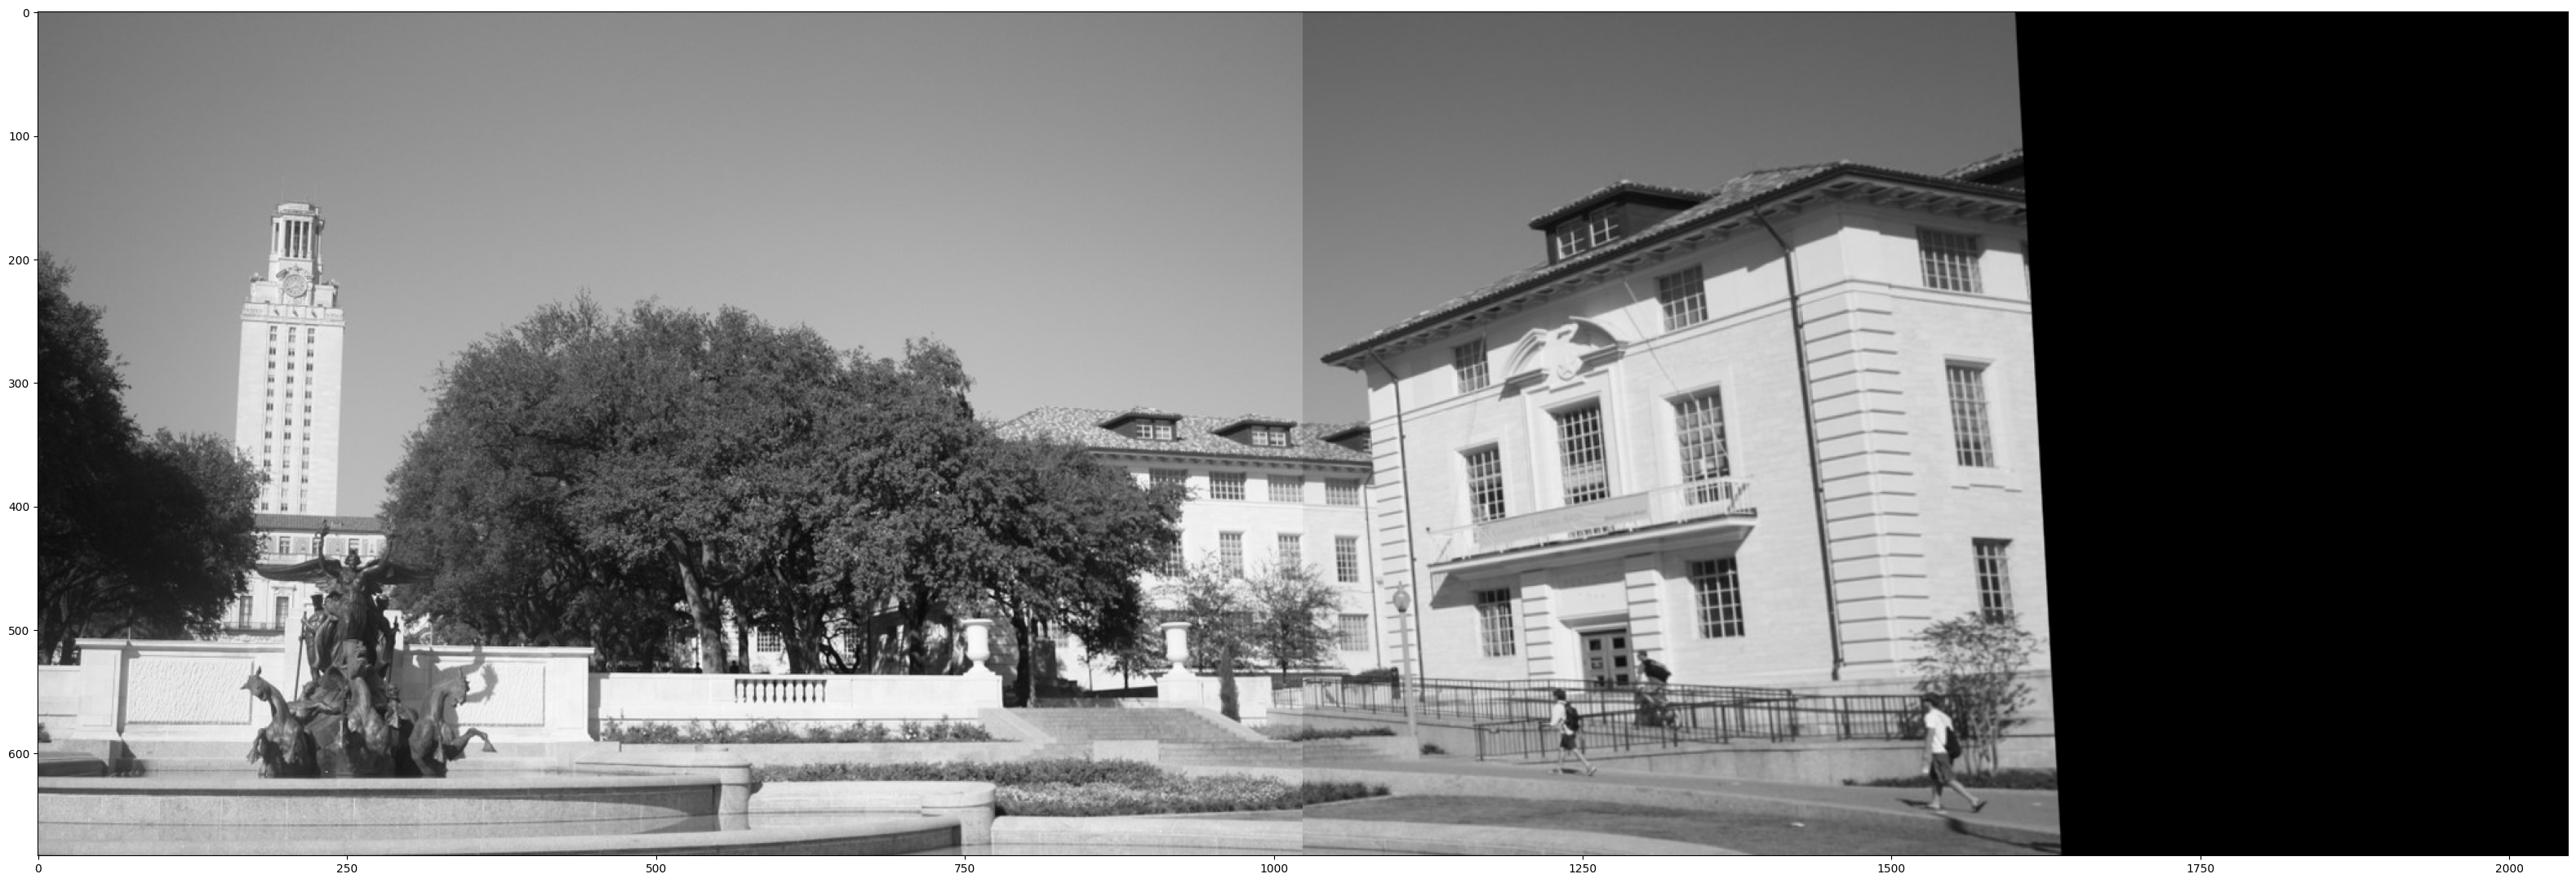

In [42]:
plt.figure(figsize=(40,20)),plt.imshow(result,cmap='gray')

**Bonus**: try other descriptors than the SIFT ones. Try to implement your own.

**Bonus:** try to correct the change of luminosity between the two images so that the panorama look more realistic.